# > Importando bibliotecas a serem usadas

In [1]:
import keras
from keras.models import Model
from keras.layers import *
from keras.optimizers import *
from keras.losses import *
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.applications.inception_v3 import InceptionV3
from keras.applications.mobilenet import MobileNet
from keras.datasets import mnist

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import pandas as pd
import matplotlib.image as mpimg
import cv2
import glob
import h5py
import random

Using TensorFlow backend.


# > Entrada dos dados:

In [2]:
with h5py.File('dataset.h5','r') as hf:
    X = hf['X'][:]
    y = hf['y'][:]
    X_test = hf['X_test'][:]

# > Parâmetros:

In [3]:
batch_size_value = 64
num_epochs = 30
learning_rate = 2.0
seed = 42

# <font color=red>A. Data augmentation</font> 

In [4]:
print(np.shape(X))
print(np.shape(X_test))

(150, 256, 256)
(50, 256, 256)


## 1. Definindo os parâmetros:

In [5]:
angulo_rot = 40
shift_largura = 0.2
shift_altura = 0.2
espelhar = True
distorcer_taxa = 0.2
zoom_taxa = 0.2

datagen = ImageDataGenerator(
        rotation_range=angulo_rot,
        width_shift_range=shift_largura,
        height_shift_range=shift_altura,
        shear_range=distorcer_taxa,
        zoom_range=zoom_taxa,
        horizontal_flip=espelhar,
        fill_mode='nearest')

## 2. Aplicando a transformação:

Imagem Original


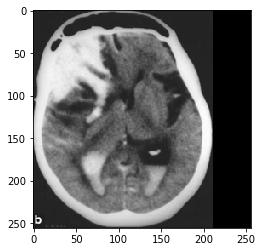

Imagens Geradas com Data Augmentation


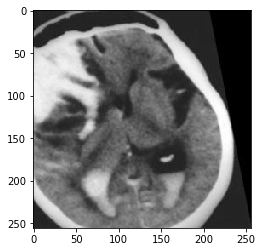

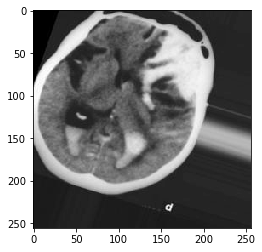

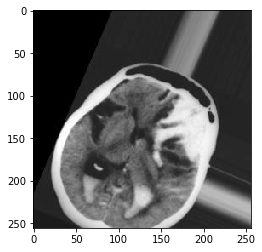

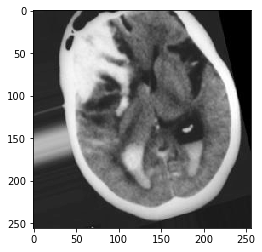

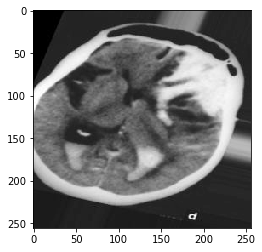

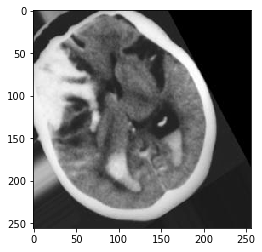

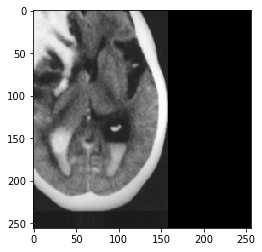

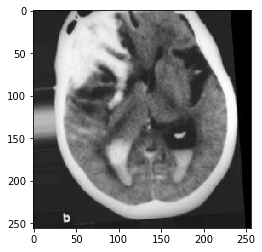

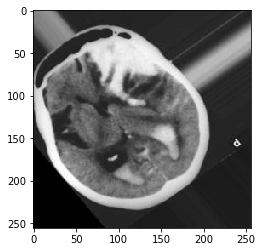

In [6]:
i = 0
img = X[0].reshape(1, 256, 256, 1)

for batch in datagen.flow(img, batch_size=1,
                          save_to_dir='preview', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i > 2:
        break  
        
print("Imagem Original")
plt.imshow(img.reshape(256, 256), cmap='gray'),plt.show()
print("Imagens Geradas com Data Augmentation")

for file in glob.glob("preview\*.jpeg"):
    img = mpimg.imread(file)
    plt.imshow(img.reshape(256, 256), cmap='gray'),plt.show()

# <font color=red> B. Um primeiro treinamento: </font>

## 1. Divisão da base de dados:

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.20, random_state = seed)

## 2. Normalização e preparação dos dados para treinamento:

In [8]:
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

X_train /=  255
X_val  /=  255
X_test /=  255

X_train = X_train.reshape(-1,256,256,1)
X_val = X_val.reshape(-1,256,256,1)
X_test = X_test.reshape(-1,256,256,1)

## 3. Definição da Arquitetura:

In [9]:
inputs = Input((256, 256,1))
Conv = Conv2D(1, kernel_size = (3,3), strides = (5, 5), padding = 'same', activation = 'linear')(inputs)
Conv = Conv2D(1, kernel_size = (3,3), strides = (5, 5), padding = 'same', activation = 'linear')(Conv)
flat = Flatten()(Conv)
dense = Dense(2,activation  =  'tanh')(flat)
dense = Dense(1, activation  =  'sigmoid')(dense)

model = Model(inputs, dense)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 52, 52, 1)         10        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 1)         10        
_________________________________________________________________
flatten_1 (Flatten)          (None, 121)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 244       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 267
Trainable params: 267
Non-trainable params: 0
_________________________________________________________________


## 4. Definindo os parâmetros de Otimização:

In [10]:
model.compile(loss = 'mean_squared_error',optimizer = SGD(lr = learning_rate), metrics = ['acc'])

## 5. Treinando:

In [11]:
history = model.fit(X_train, y_train,
          batch_size = batch_size_value,
          epochs = num_epochs,
          verbose = 1,
          validation_data = (X_val, y_val))

Train on 120 samples, validate on 30 samples
Epoch 1/30
120/120 [==============================] - 3s 21ms/step - loss: 0.2478 - acc: 0.5500 - val_loss: 0.2816 - val_acc: 0.5000
Epoch 2/30
120/120 [==============================] - 0s 451us/step - loss: 0.2561 - acc: 0.5333 - val_loss: 0.3533 - val_acc: 0.5000
Epoch 3/30
120/120 [==============================] - 0s 443us/step - loss: 0.3789 - acc: 0.4833 - val_loss: 0.3476 - val_acc: 0.5000
Epoch 4/30
120/120 [==============================] - 0s 434us/step - loss: 0.3313 - acc: 0.4833 - val_loss: 0.2570 - val_acc: 0.5000
Epoch 5/30
120/120 [==============================] - 0s 451us/step - loss: 0.2590 - acc: 0.4667 - val_loss: 0.2502 - val_acc: 0.5000
Epoch 6/30
120/120 [==============================] - 0s 451us/step - loss: 0.2507 - acc: 0.4583 - val_loss: 0.2514 - val_acc: 0.5000
Epoch 7/30
120/120 [==============================] - 0s 418us/step - loss: 0.2499 - acc: 0.5167 - val_loss: 0.2506 - val_acc: 0.5000
Epoch 8/30
120/120

## 6. Plotando os gráficos de erro e acurácia:

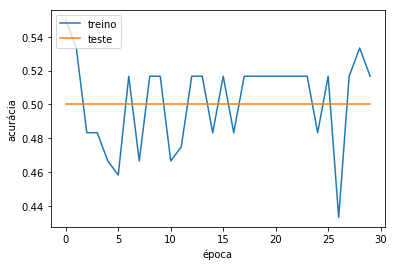

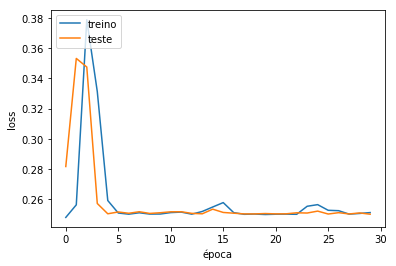

In [12]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('acurácia')
plt.xlabel('época')
plt.legend(['treino', 'teste'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('época')
plt.legend(['treino', 'teste'], loc = 'upper left')
plt.show()

### 7. Salvando o arquivo com o desempenho obtido:

In [13]:
prediction  =  model.predict(X_test)
np.savetxt('resultado.csv', prediction)

# <font color=red> C. Modificando a arquitetura </font>

## 1. Numero de filtros por camada

In [14]:
num_filtros_camada_1 = 32
num_filtros_camada_2 = 64

num_neuronios_camada_1 = 64
num_neuronios_camada_2 = 1

In [15]:

Conv = Conv2D(num_filtros_camada_1, kernel_size = (3,3), strides = (5, 5), padding = 'same', activation = 'linear')(inputs)
Conv = Conv2D(num_filtros_camada_1, kernel_size = (3,3), strides = (5, 5), padding = 'same', activation = 'linear')(Conv)

Conv = Conv2D(num_filtros_camada_2, kernel_size = (3,3), strides = (5, 5), padding = 'same', activation = 'linear')(Conv)
Conv = Conv2D(num_filtros_camada_2, kernel_size = (3,3), strides = (5, 5), padding = 'same', activation = 'linear')(Conv)

flat = Flatten()(Conv)

dense = Dense(num_neuronios_camada_1,activation  =  'tanh')(flat)
dense = Dense(num_neuronios_camada_1,activation  =  'tanh')(dense)
dense = Dense(num_neuronios_camada_2, activation  =  'sigmoid')(dense)

model = Model(inputs, dense)
model.compile(loss = 'mean_squared_error', optimizer = SGD(lr = learning_rate), metrics = ['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 64)          18496     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 1, 1, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
__________

#  <font color=red> D. Variando taxa de aprendizado <color>

### 1. Taxa de Aprendizado igual a 3.0:

In [16]:
# Variar a taxa de aprendizado e verificar o impacto no treinamento

learning_rate = 3

model.compile(loss = 'mean_squared_error', optimizer = SGD(lr = learning_rate), metrics = ['acc'])
history = model.fit(X_train, y_train,
          batch_size = batch_size_value,
          epochs = num_epochs,
          verbose = 1,
          validation_data = (X_val, y_val))

Train on 120 samples, validate on 30 samples
Epoch 1/30
120/120 [==============================] - 0s 3ms/step - loss: 0.3411 - acc: 0.5167 - val_loss: 0.2572 - val_acc: 0.5000
Epoch 2/30
120/120 [==============================] - 0s 518us/step - loss: 0.2796 - acc: 0.5333 - val_loss: 0.2738 - val_acc: 0.5000
Epoch 3/30
120/120 [==============================] - 0s 526us/step - loss: 0.3004 - acc: 0.5833 - val_loss: 0.3107 - val_acc: 0.5000
Epoch 4/30
120/120 [==============================] - 0s 534us/step - loss: 0.3700 - acc: 0.5167 - val_loss: 0.3847 - val_acc: 0.5000
Epoch 5/30
120/120 [==============================] - 0s 551us/step - loss: 0.3469 - acc: 0.4833 - val_loss: 0.3297 - val_acc: 0.5000
Epoch 6/30
120/120 [==============================] - 0s 535us/step - loss: 0.3214 - acc: 0.4833 - val_loss: 0.4995 - val_acc: 0.5000
Epoch 7/30
120/120 [==============================] - 0s 510us/step - loss: 0.4827 - acc: 0.5167 - val_loss: 0.4988 - val_acc: 0.5000
Epoch 8/30
120/120 

### 2. Taxa de Aprendizado igual a 1.0:

In [17]:
# Variar a taxa de aprendizado e verificar o impacto no treinamento

learning_rate = 0.5

model.compile(loss = 'mean_squared_error',optimizer = SGD(lr = learning_rate), metrics = ['acc'])
history = model.fit(X_train, y_train,
          batch_size = batch_size_value,
          epochs = num_epochs,
          verbose = 1,
          validation_data = (X_val, y_val))

Train on 120 samples, validate on 30 samples
Epoch 1/30
120/120 [==============================] - 0s 2ms/step - loss: 0.4832 - acc: 0.5167 - val_loss: 0.4999 - val_acc: 0.5000
Epoch 2/30
120/120 [==============================] - 0s 501us/step - loss: 0.4832 - acc: 0.5167 - val_loss: 0.4999 - val_acc: 0.5000
Epoch 3/30
120/120 [==============================] - 0s 501us/step - loss: 0.4832 - acc: 0.5167 - val_loss: 0.4999 - val_acc: 0.5000
Epoch 4/30
120/120 [==============================] - 0s 518us/step - loss: 0.4832 - acc: 0.5167 - val_loss: 0.4999 - val_acc: 0.5000
Epoch 5/30
120/120 [==============================] - 0s 518us/step - loss: 0.4832 - acc: 0.5167 - val_loss: 0.4999 - val_acc: 0.5000
Epoch 6/30
120/120 [==============================] - 0s 526us/step - loss: 0.4832 - acc: 0.5167 - val_loss: 0.4999 - val_acc: 0.5000
Epoch 7/30
120/120 [==============================] - 0s 535us/step - loss: 0.4832 - acc: 0.5167 - val_loss: 0.4998 - val_acc: 0.5000
Epoch 8/30
120/120 

### 3. Taxa de aprendizado (learning_rate) - Modifique manualmente:

In [18]:
# Variar a taxa de aprendizado e verificar o impacto no treinamento

# Inserir nova learning_rate

#nova_learning_rate = novo_valor
#learning_rate = nova_learning_rate

model.compile(loss = 'mean_squared_error', optimizer = SGD(lr = learning_rate), metrics = ['acc'])
history = model.fit(X_train, y_train,
          batch_size = batch_size_value,
          epochs = num_epochs,
          verbose = 1,
          validation_data = (X_val, y_val))

Train on 120 samples, validate on 30 samples
Epoch 1/30
120/120 [==============================] - 0s 3ms/step - loss: 0.4832 - acc: 0.5167 - val_loss: 0.4998 - val_acc: 0.5000
Epoch 2/30
120/120 [==============================] - 0s 526us/step - loss: 0.4832 - acc: 0.5167 - val_loss: 0.4998 - val_acc: 0.5000
Epoch 3/30
120/120 [==============================] - 0s 526us/step - loss: 0.4832 - acc: 0.5167 - val_loss: 0.4998 - val_acc: 0.5000
Epoch 4/30
120/120 [==============================] - 0s 501us/step - loss: 0.4832 - acc: 0.5167 - val_loss: 0.4998 - val_acc: 0.5000
Epoch 5/30
120/120 [==============================] - 0s 526us/step - loss: 0.4832 - acc: 0.5167 - val_loss: 0.4998 - val_acc: 0.5000
Epoch 6/30
120/120 [==============================] - 0s 526us/step - loss: 0.4832 - acc: 0.5167 - val_loss: 0.4998 - val_acc: 0.5000
Epoch 7/30
120/120 [==============================] - 0s 518us/step - loss: 0.4832 - acc: 0.5167 - val_loss: 0.4998 - val_acc: 0.5000
Epoch 8/30
120/120 

#  <font color=red>E. Variar o parâmetro Batch Size<font>

### 1. Batch Size = 32

In [19]:
batch_size_value = 32

model.compile(loss = 'mean_squared_error', optimizer = SGD(lr = learning_rate), metrics = ['acc'])
history = model.fit(X_train, y_train,
          batch_size = batch_size_value,
          epochs = num_epochs,
          verbose = 1,
          validation_data = (X_val, y_val))

Train on 120 samples, validate on 30 samples
Epoch 1/30
120/120 [==============================] - 0s 3ms/step - loss: 0.4831 - acc: 0.5167 - val_loss: 0.4998 - val_acc: 0.5000
Epoch 2/30
120/120 [==============================] - 0s 576us/step - loss: 0.4831 - acc: 0.5167 - val_loss: 0.4998 - val_acc: 0.5000
Epoch 3/30
120/120 [==============================] - 0s 560us/step - loss: 0.4831 - acc: 0.5167 - val_loss: 0.4997 - val_acc: 0.5000
Epoch 4/30
120/120 [==============================] - 0s 560us/step - loss: 0.4831 - acc: 0.5167 - val_loss: 0.4997 - val_acc: 0.5000
Epoch 5/30
120/120 [==============================] - 0s 560us/step - loss: 0.4831 - acc: 0.5167 - val_loss: 0.4997 - val_acc: 0.5000
Epoch 6/30
120/120 [==============================] - 0s 585us/step - loss: 0.4831 - acc: 0.5167 - val_loss: 0.4997 - val_acc: 0.5000
Epoch 7/30
120/120 [==============================] - 0s 577us/step - loss: 0.4831 - acc: 0.5167 - val_loss: 0.4997 - val_acc: 0.5000
Epoch 8/30
120/120 

### 2. Batch Size = 128

In [20]:
batch_size_value = 128

model.compile(loss = 'mean_squared_error', optimizer = SGD(lr = learning_rate), metrics = ['acc'])
history = model.fit(X_train, y_train,
          batch_size = batch_size_value,
          epochs = num_epochs,
          verbose = 1,
          validation_data = (X_val, y_val))

Train on 120 samples, validate on 30 samples
Epoch 1/30
120/120 [==============================] - 0s 3ms/step - loss: 0.4827 - acc: 0.5167 - val_loss: 0.4993 - val_acc: 0.5000
Epoch 2/30
120/120 [==============================] - 0s 451us/step - loss: 0.4827 - acc: 0.5167 - val_loss: 0.4993 - val_acc: 0.5000
Epoch 3/30
120/120 [==============================] - 0s 460us/step - loss: 0.4827 - acc: 0.5167 - val_loss: 0.4993 - val_acc: 0.5000
Epoch 4/30
120/120 [==============================] - 0s 426us/step - loss: 0.4827 - acc: 0.5167 - val_loss: 0.4993 - val_acc: 0.5000
Epoch 5/30
120/120 [==============================] - 0s 468us/step - loss: 0.4826 - acc: 0.5167 - val_loss: 0.4993 - val_acc: 0.5000
Epoch 6/30
120/120 [==============================] - 0s 434us/step - loss: 0.4826 - acc: 0.5167 - val_loss: 0.4993 - val_acc: 0.5000
Epoch 7/30
120/120 [==============================] - 0s 485us/step - loss: 0.4826 - acc: 0.5167 - val_loss: 0.4993 - val_acc: 0.5000
Epoch 8/30
120/120 

### 3. Batch Size - Modifique manualmente

In [21]:
#batch_size_value = novo_valor

In [22]:
model.compile(loss = 'mean_squared_error', optimizer = SGD(lr = learning_rate), metrics = ['acc'])
history = model.fit(X_train, y_train,
          batch_size = batch_size_value,
          epochs = num_epochs,
          verbose = 1,
          validation_data = (X_val, y_val))

Train on 120 samples, validate on 30 samples
Epoch 1/30
120/120 [==============================] - 0s 3ms/step - loss: 0.4822 - acc: 0.5167 - val_loss: 0.4988 - val_acc: 0.5000
Epoch 2/30
120/120 [==============================] - 0s 443us/step - loss: 0.4821 - acc: 0.5167 - val_loss: 0.4987 - val_acc: 0.5000
Epoch 3/30
120/120 [==============================] - 0s 535us/step - loss: 0.4821 - acc: 0.5167 - val_loss: 0.4987 - val_acc: 0.5000
Epoch 4/30
120/120 [==============================] - 0s 460us/step - loss: 0.4821 - acc: 0.5167 - val_loss: 0.4987 - val_acc: 0.5000
Epoch 5/30
120/120 [==============================] - 0s 485us/step - loss: 0.4820 - acc: 0.5167 - val_loss: 0.4986 - val_acc: 0.5000
Epoch 6/30
120/120 [==============================] - 0s 468us/step - loss: 0.4820 - acc: 0.5167 - val_loss: 0.4986 - val_acc: 0.5000
Epoch 7/30
120/120 [==============================] - 0s 501us/step - loss: 0.4820 - acc: 0.5167 - val_loss: 0.4985 - val_acc: 0.5000
Epoch 8/30
120/120 

In [23]:
history = model.fit(X_train, y_train,
          batch_size = batch_size_value,
          epochs = num_epochs,
          verbose = 1,
          validation_data = (X_val, y_val))

Train on 120 samples, validate on 30 samples
Epoch 1/30
120/120 [==============================] - 0s 468us/step - loss: 0.4782 - acc: 0.5167 - val_loss: 0.4941 - val_acc: 0.5000
Epoch 2/30
120/120 [==============================] - 0s 468us/step - loss: 0.4776 - acc: 0.5167 - val_loss: 0.4932 - val_acc: 0.5000
Epoch 3/30
120/120 [==============================] - 0s 476us/step - loss: 0.4768 - acc: 0.5167 - val_loss: 0.4922 - val_acc: 0.5000
Epoch 4/30
120/120 [==============================] - 0s 468us/step - loss: 0.4758 - acc: 0.5167 - val_loss: 0.4907 - val_acc: 0.5000
Epoch 5/30
120/120 [==============================] - 0s 460us/step - loss: 0.4744 - acc: 0.5167 - val_loss: 0.4887 - val_acc: 0.5000
Epoch 6/30
120/120 [==============================] - 0s 460us/step - loss: 0.4724 - acc: 0.5167 - val_loss: 0.4857 - val_acc: 0.5000
Epoch 7/30
120/120 [==============================] - 0s 460us/step - loss: 0.4695 - acc: 0.5167 - val_loss: 0.4807 - val_acc: 0.5000
Epoch 8/30
120/12

# <font color=red>F. Transfer Learning <font>

### 1. Leitura da base de dados EMNIST:

In [24]:
X_train = np.load('X_train.npy')
X_val = np.load('X_val.npy')
y_train = np.load('y_train.npy')
y_val = np.load('y_val.npy')
print(np.shape(X_train))
print(np.shape(X_val))

(3993, 28, 28, 1)
(999, 28, 28, 1)


### 2. Conversão para One-Hot Encoding:

In [25]:
y_train2 = keras.utils.to_categorical(np.subtract(y_train,1), 26)
y_test2 = keras.utils.to_categorical(np.subtract(y_val,1), 26)

### 3. Treinando um modelo SEM transfer learning:

#### > Definindo a Arquitetura

In [26]:
model_transfer_learning = Sequential()
model_transfer_learning.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=(28, 28, 1)))
model_transfer_learning.add(Conv2D(64, (3, 3), activation='relu'))
model_transfer_learning.add(Conv2D(64, (3, 3), activation='relu'))
model_transfer_learning.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_transfer_learning.add(Conv2D(64, (3, 3), activation='relu'))
model_transfer_learning.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_transfer_learning.add(Conv2D(64, (3, 3), activation='relu'))
model_transfer_learning.add(MaxPooling2D(pool_size=(2, 2)))
model_transfer_learning.add(Flatten())
model_transfer_learning.add(Dense(128, activation='relu'))
model_transfer_learning.add(Dense(26, activation='softmax'))

model_transfer_learning.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 20, 20, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 2, 2, 64)          36928     
__________

#### > Treinamento:

In [27]:
model_transfer_learning.compile(loss=categorical_crossentropy,
              optimizer=RMSprop(lr=0.01),
              metrics=['accuracy'])

history_transfer_learning = model_transfer_learning.fit(X_train, y_train2,
          batch_size=batch_size_value,
          epochs=30,
          verbose=1,
          validation_data=(X_val, y_test2))

Train on 3993 samples, validate on 999 samples
Epoch 1/30
3993/3993 [==============================] - 1s 272us/step - loss: 15.1406 - acc: 0.0358 - val_loss: 15.5695 - val_acc: 0.0340
Epoch 2/30
3993/3993 [==============================] - 1s 135us/step - loss: 15.5409 - acc: 0.0358 - val_loss: 15.5695 - val_acc: 0.0340
Epoch 3/30
3993/3993 [==============================] - 1s 133us/step - loss: 15.5409 - acc: 0.0358 - val_loss: 15.5695 - val_acc: 0.0340
Epoch 4/30
3993/3993 [==============================] - 1s 141us/step - loss: 15.5409 - acc: 0.0358 - val_loss: 15.5695 - val_acc: 0.0340
Epoch 5/30
3993/3993 [==============================] - 1s 134us/step - loss: 15.5409 - acc: 0.0358 - val_loss: 15.5695 - val_acc: 0.0340
Epoch 6/30
3993/3993 [==============================] - 1s 133us/step - loss: 15.5409 - acc: 0.0358 - val_loss: 15.5695 - val_acc: 0.0340
Epoch 7/30
3993/3993 [==============================] - 1s 134us/step - loss: 15.5409 - acc: 0.0358 - val_loss: 15.5695 - val

#### > Exibindo o desempenho:

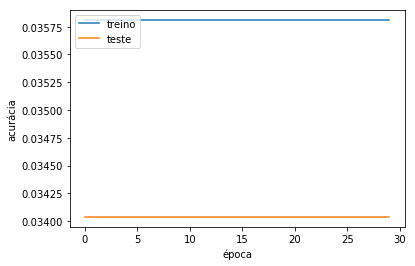

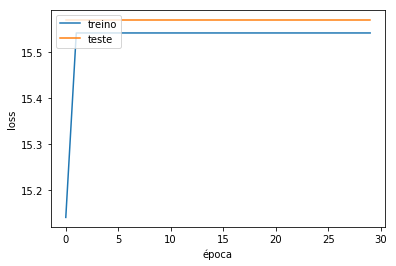

In [28]:
plt.plot(history_transfer_learning.history['acc'])
plt.plot(history_transfer_learning.history['val_acc'])
plt.ylabel('acurácia')
plt.xlabel('época')
plt.legend(['treino', 'teste'], loc = 'upper left')
plt.show()

plt.plot(history_transfer_learning.history['loss'])
plt.plot(history_transfer_learning.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('época')
plt.legend(['treino', 'teste'], loc = 'upper left')
plt.show()

## 6. Treinando um modelo COM transfer learning

#### > Definindo a Arquitetura

In [29]:
model_transfer_learning = Sequential()
model_transfer_learning.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=(28, 28, 1)))
model_transfer_learning.add(Conv2D(64, (3, 3), activation='relu'))
model_transfer_learning.add(Conv2D(64, (3, 3), activation='relu'))
model_transfer_learning.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_transfer_learning.add(Conv2D(64, (3, 3), activation='relu'))
model_transfer_learning.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_transfer_learning.add(Conv2D(64, (3, 3), activation='relu'))
model_transfer_learning.add(MaxPooling2D(pool_size=(2, 2)))
model_transfer_learning.add(Flatten())
model_transfer_learning.add(Dense(128, activation='relu'))
model_transfer_learning.add(Dense(10, activation='softmax'))

model_transfer_learning.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 22, 22, 64)        18496     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 20, 20, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 2, 2, 64)          36928     
__________

#### > Lendo o conjunto de pesos de uma arquitetura treinada no dataset MNIST:

In [30]:
model_transfer_learning.load_weights("model_transfer_learning.h5")

#### > "Congelando" os pesos das camadas convolucionais:

In [31]:
for layer in model_transfer_learning.layers[:-2]:
    layer.trainable = False
    
for layer in model_transfer_learning.layers:
    print(layer, layer.trainable)

<keras.layers.convolutional.Conv2D object at 0x0000029B2A346898> False
<keras.layers.convolutional.Conv2D object at 0x0000029B2A346080> False
<keras.layers.convolutional.Conv2D object at 0x0000029B2A346940> False
<keras.layers.pooling.MaxPooling2D object at 0x0000029B2A346A58> False
<keras.layers.convolutional.Conv2D object at 0x0000029B29315080> False
<keras.layers.pooling.MaxPooling2D object at 0x0000029B2A3ECAC8> False
<keras.layers.convolutional.Conv2D object at 0x0000029B2A3FC438> False
<keras.layers.pooling.MaxPooling2D object at 0x0000029B2A40BC88> False
<keras.layers.core.Flatten object at 0x0000029B2A41C828> False
<keras.layers.core.Dense object at 0x0000029B2A42C668> True
<keras.layers.core.Dense object at 0x0000029B2A42C9E8> True


#### > Removendo as camadas Fully Connected:

In [32]:
model_transfer_learning.layers.pop()
model_transfer_learning.layers.pop()
model_transfer_learning.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 22, 22, 64)        18496     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 20, 20, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 2, 2, 64)          36928     
__________

#### > Adicionando novas camadas Fully-Connected para o nosso problema:

In [33]:
model_transfer_learning.add(Dense(128, activation='relu'))
model_transfer_learning.add(Dense(26, activation='softmax'))
model_transfer_learning.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 22, 22, 64)        18496     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 20, 20, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 2, 2, 64)          36928     
__________

#### > Treinamento:

In [34]:
model_transfer_learning.compile(loss=categorical_crossentropy,
              optimizer=RMSprop(lr=0.01),
              metrics=['accuracy'])

history_transfer_learning = model_transfer_learning.fit(X_train, y_train2,
          batch_size=batch_size_value,
          epochs=50,
          verbose=1,
          validation_data=(X_val, y_test2))

Train on 3993 samples, validate on 999 samples
Epoch 1/50
3993/3993 [==============================] - 1s 186us/step - loss: 3.2405 - acc: 0.0523 - val_loss: 3.1403 - val_acc: 0.0781
Epoch 2/50
3993/3993 [==============================] - 0s 94us/step - loss: 2.9315 - acc: 0.1232 - val_loss: 2.7523 - val_acc: 0.1742
Epoch 3/50
3993/3993 [==============================] - 0s 89us/step - loss: 2.6977 - acc: 0.1776 - val_loss: 2.7782 - val_acc: 0.1311
Epoch 4/50
3993/3993 [==============================] - 0s 88us/step - loss: 2.5935 - acc: 0.1896 - val_loss: 2.5127 - val_acc: 0.1972
Epoch 5/50
3993/3993 [==============================] - 0s 87us/step - loss: 2.4917 - acc: 0.2332 - val_loss: 2.5013 - val_acc: 0.2312
Epoch 6/50
3993/3993 [==============================] - 0s 83us/step - loss: 2.3853 - acc: 0.2650 - val_loss: 2.3998 - val_acc: 0.2312
Epoch 7/50
3993/3993 [==============================] - 0s 85us/step - loss: 2.3141 - acc: 0.2800 - val_loss: 2.4036 - val_acc: 0.2513
Epoch 8

#### > Exibindo o desempenho:

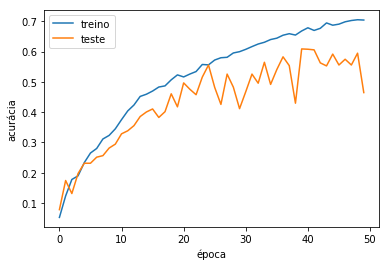

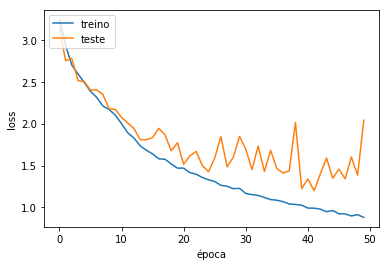

In [35]:
plt.plot(history_transfer_learning.history['acc'])
plt.plot(history_transfer_learning.history['val_acc'])
plt.ylabel('acurácia')
plt.xlabel('época')
plt.legend(['treino', 'teste'], loc = 'upper left')
plt.show()

plt.plot(history_transfer_learning.history['loss'])
plt.plot(history_transfer_learning.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('época')
plt.legend(['treino', 'teste'], loc = 'upper left')
plt.show()